# Feature selection dropping NaN values

### Import of all necessary libaries and check if MPS is available for faster computation

In [1]:
from src.utils.check_mps_device import check_mps_device
import pandas as pd

from src.utils.data_loading import load_data
from src.utils.filtering import filter_data

from src.utils.label_encoding import label_encode_column

import seaborn as sns
import matplotlib.pyplot as plt

# Check if PyTorch Multi-Process Service (MPS) is available (GPU)
check_mps_device()

tensor([1.], device='mps:0')


In the following four different Feature Selection Techniques are applied.
The first three (Univariate Selection, Feature Importance, Correlation) are explained in this [Article](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e)

The fourth (quantum-classical hybrid solver) follows the [dwave-scikit-learn-plugin](https://github.com/dwavesystems/dwave-scikit-learn-plugin)#

## 1. Univariate Selection
This methods makes use of the [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) class that evaluates the top k features based on the [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) function.
It measures the amount of information shared between two variables, and computes the mutual information between each feature and the target variable in a classification task [ref](https://medium.com/@Kavya2099/optimizing-performance-selectkbest-for-efficient-feature-selection-in-machine-learning-3b635905ed48#:~:text=SelectKBest%20uses%20statistical%20tests%20like,in%20the%20final%20feature%20subset).


Raw data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162634 entries, 0 to 162633
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 127.8+ MB
Filtered data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 2.4+ MB


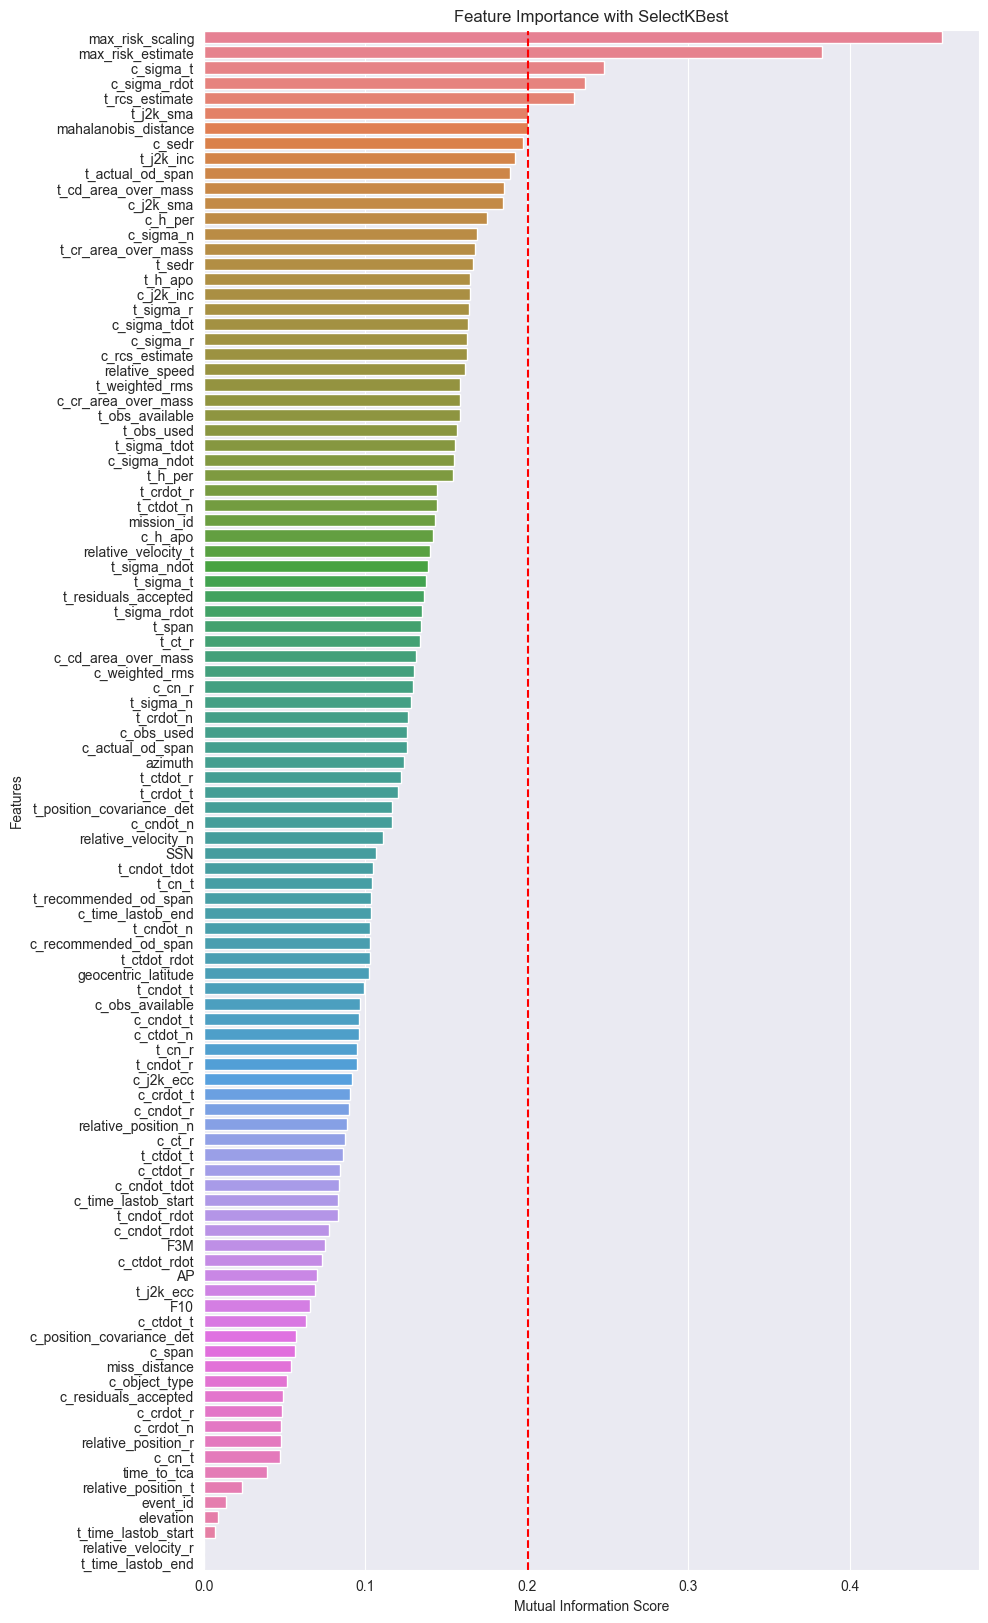

Top 5 selected features: ['max_risk_scaling', 'max_risk_estimate', 'c_sigma_t', 'c_sigma_rdot', 't_rcs_estimate']


In [2]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Load and data and filter it
df = load_data()
df_filtered = filter_data(df)

# Remove rows with missing values
df_filtered.dropna(axis=0, how="any", inplace=True)

# Label encode the categorical column "c_object_type"
label_encode_column(df_filtered, "c_object_type")

# Separate features and target variable
X = df_filtered.drop(["risk"], axis=1)
y = df_filtered["risk"]

# Feature selection using SelectKBest with mutual_info_regression and all features (k='all')
selector = SelectKBest(score_func=mutual_info_regression, k="all")
# Evaluate the scoring function for each feature in the dataset
X_selected = selector.fit_transform(X, y)

# Get the selected feature names
selected_feature_names = X.columns[selector.get_support()]

# Get the feature scores
feature_scores = selector.scores_

# Create a DataFrame with selected features and their scores
selected_features_df = pd.DataFrame(
    {"Feature": selected_feature_names, "Score": feature_scores[selector.get_support()]}
)
selected_features_df = selected_features_df.sort_values(by="Score", ascending=False)

# Plot the feature scores using Seaborn
plt.figure(figsize=(10, 20))
sns.barplot(x="Score", y="Feature", data=selected_features_df, hue="Feature")

# Add a line to visualize the elbow point
elbow_point = 6
plt.axvline(
    x=selected_features_df["Score"].iloc[elbow_point - 1],
    color="red",
    linestyle="--",
    label="Elbow Point",
)

plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.title("Feature Importance with SelectKBest")
plt.show()

# Select the top x features based on the elbow method
selected_features_kbest = selected_features_df[: elbow_point - 1]
selected_features_kbest = selected_features_kbest["Feature"].tolist()
print(f"Top {elbow_point - 1} selected features:", selected_features_kbest)

## 2. Feature Importance with ExtraTreesRegressor
This feature usess the [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html) class.
It builds a collection of decision trees and makes predictions by averaging the outputs of these individual trees. The "Extra" in Extra Trees refers to the fact that, unlike traditional Random Forests, it selects split points for nodes randomly, without any optimization process

Raw data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162634 entries, 0 to 162633
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 127.8+ MB
Filtered data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 2.4+ MB


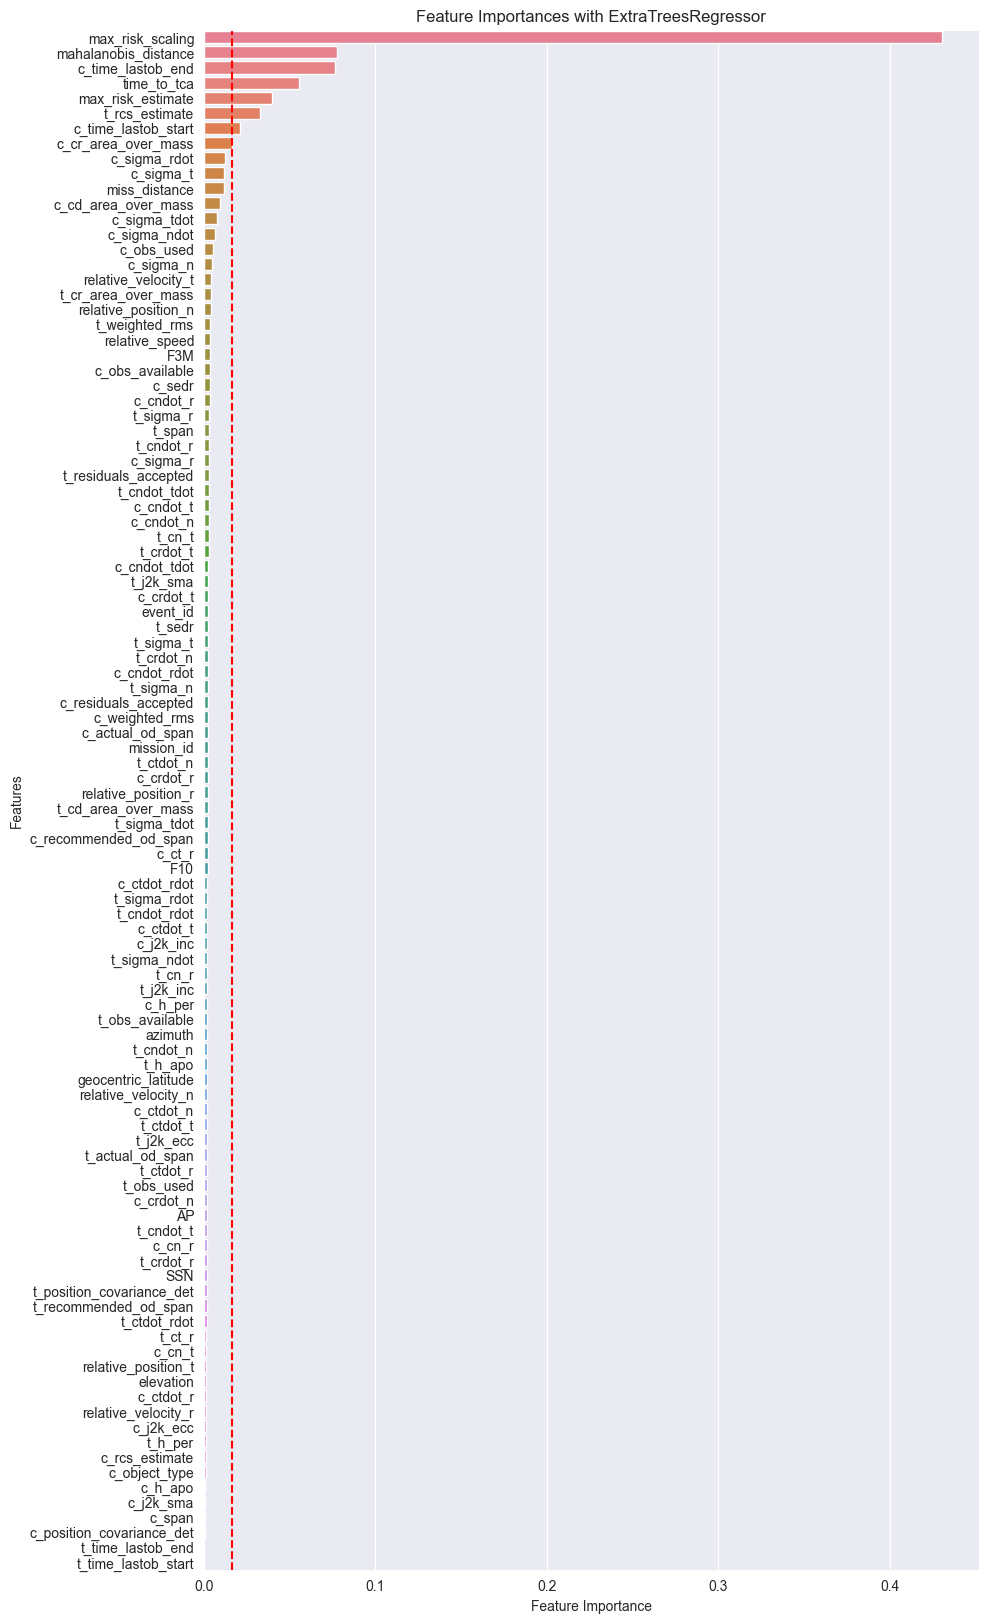

Top 7 selected features: ['max_risk_scaling', 'mahalanobis_distance', 'c_time_lastob_end', 'time_to_tca', 'max_risk_estimate', 't_rcs_estimate', 'c_time_lastob_start']


In [3]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load and data and filter it
df = load_data()
df_filtered = filter_data(df)

# Drop rows with NaN values
df_filtered.dropna(axis=0, how="any", inplace=True)

# Encode categorical column "c_object_type"
label_encode_column(df_filtered, "c_object_type")

# Separate features (X) and target variable (y)
X = df_filtered.drop(["risk"], axis=1)
y = df_filtered["risk"]

# Scale the features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(X)

# Train the ExtraTreesRegressor model
model = ExtraTreesRegressor()
model.fit(features_scaled, y)

# Plot the feature scores using Seaborn
plt.figure(figsize=(10, 20))

# Create a DataFrame with feature names and their importances
feat_importances = pd.DataFrame(
    {"Feature": X.columns, "Importance": model.feature_importances_}
)
# Sort the DataFrame by importance in descending order
feat_importances = feat_importances.sort_values(by="Importance", ascending=False)

# Plot the feature importances using Seaborn
sns.barplot(x="Importance", y="Feature", data=feat_importances, hue="Feature")

# Add a line to visualize the elbow point
elbow_point = 8
plt.axvline(
    x=feat_importances["Importance"].iloc[elbow_point - 1],
    color="red",
    linestyle="--",
    label="Elbow Point",
)

plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances with ExtraTreesRegressor")
plt.show()

# Select the top x features based on the elbow method
selected_features_regressor = feat_importances[: elbow_point - 1]
selected_features_regressor = selected_features_regressor["Feature"].tolist()
print(f"Top {elbow_point - 1} selected features:", selected_features_regressor)

## 3. Correlation Matrix
The ```corr()``` method in pandas calculates the Pearson correlation coefficient by default. 
This coefficient quantifies the strength and direction of a linear relationship between two variables, ranging from -1 to 1:

- 1: Perfect positive correlation (both variables increase linearly).
- 0: No linear correlation.
- -1: Perfect negative correlation (one variable increases, the other decreases linearly).

Raw data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162634 entries, 0 to 162633
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 127.8+ MB
Filtered data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 2.4+ MB


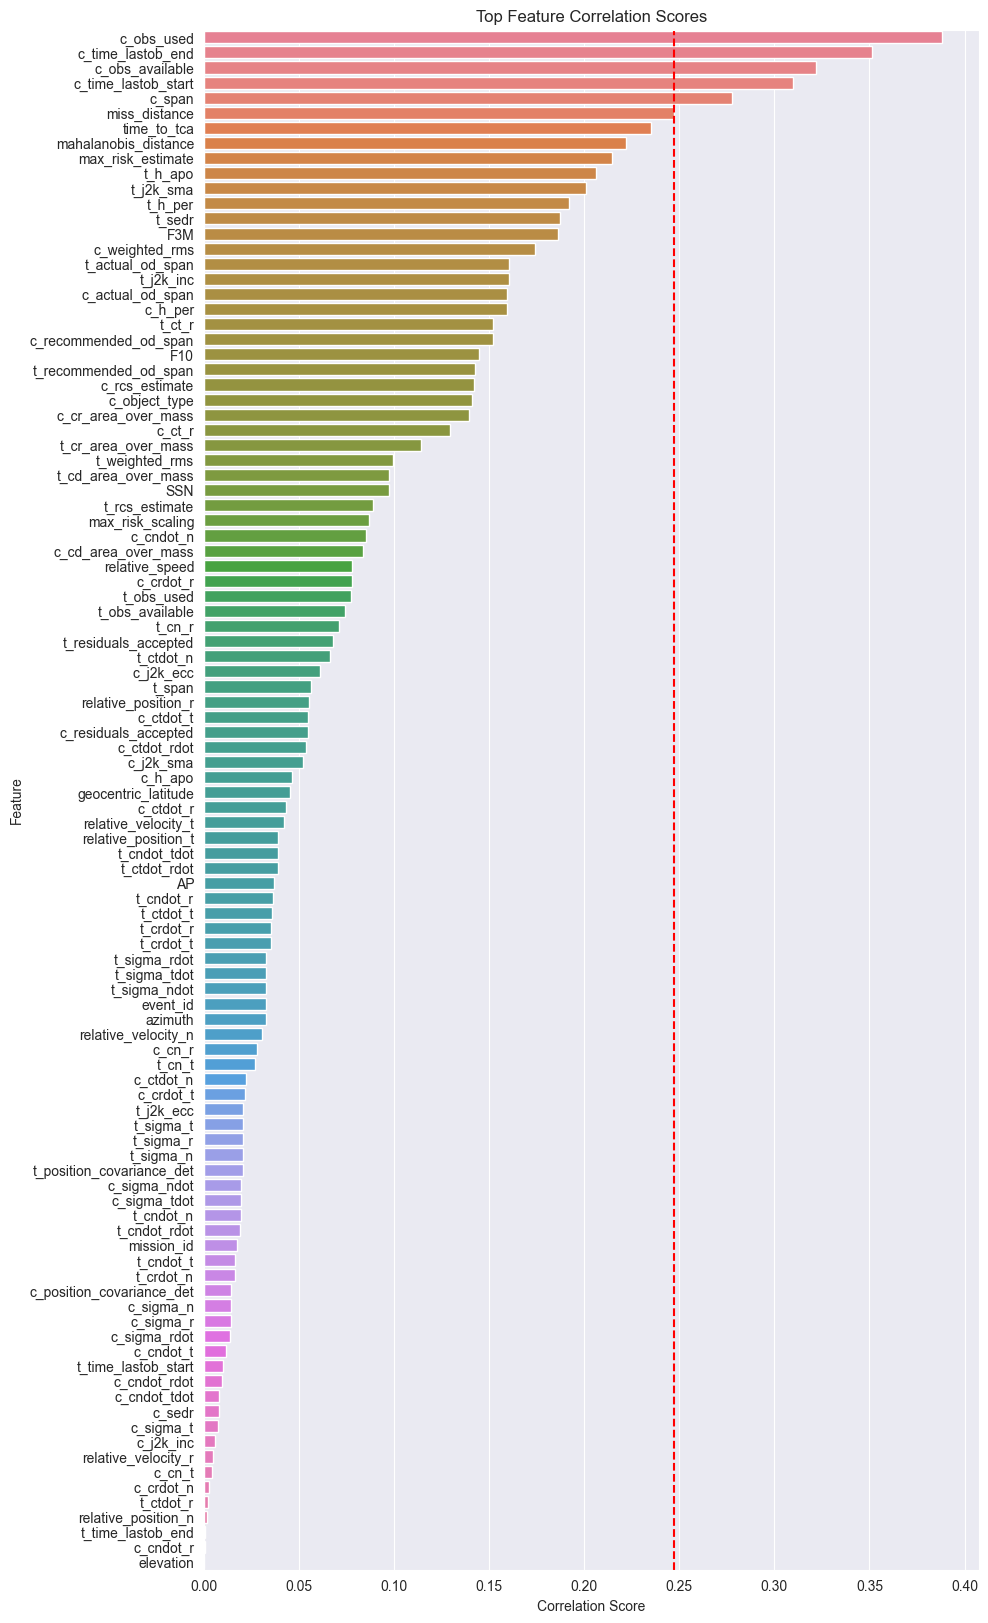

Top 5 selected features: ['c_obs_used', 'c_time_lastob_end', 'c_obs_available', 'c_time_lastob_start', 'c_span']


In [4]:
# Load and data and filter it
df = load_data()
df_filtered = filter_data(df)

# Label encode a specific categorical column ("c_object_type")
label_encode_column(df_filtered, "c_object_type")

# Calculate the correlation matrix for the filtered data
correlation_matrix = df_filtered.corr()

# Identify features with high correlation with the target variable ("risk")
target_correlation = correlation_matrix["risk"].abs().sort_values(ascending=False)

# Exclude the target variable to get the best features
best_features = target_correlation[1:]

# Plot the correlation scores of the top features
plt.figure(figsize=(10, 20))
sns.barplot(x=best_features.values, y=best_features.index, hue=best_features.index)

elbow_point = 6
plt.axvline(
    x=best_features.iloc[elbow_point - 1],
    color="red",
    linestyle="--",
    label="Elbow Point",
)

plt.title("Top Feature Correlation Scores")
plt.xlabel("Correlation Score")
plt.ylabel("Feature")
plt.show()

# Select the top x features based on the elbow method
selected_features_corr = best_features.index[: elbow_point - 1].tolist()
print(f"Top {elbow_point - 1} selected features:", selected_features_corr)

## 4. D-Wave scikit-learn Plugin using a quantum-classical hybrid solver.
This plugin selects features using a [quadratic optimization](https://docs.ocean.dwavesys.com/en/stable/concepts/cqm.html#constrained-quadratic-models) problem that is solved on a [hybrid solver](https://docs.ocean.dwavesys.com/en/stable/concepts/hybrid.html).

To use the solver you need to:
- Create a free account on [dwave](https://cloud.dwavesys.com/leap/signup/)
- Create a [Configuration File](https://docs.ocean.dwavesys.com/en/stable/overview/sapi.html) with ```dwave config create --auto-token``` by adding your [Solver API Token](https://cloud.dwavesys.com/leap/).
- Verify the configuration with ```dwave ping --client qpu```

In [5]:
from dwave.plugins.sklearn import SelectFromQuadraticModel
from dwave.cloud import Client

# Connect to D-Wave cloud service
with Client.from_config() as client:
    solver = client.get_solver()
    print("Solver ID:", solver.id)

# Load and data and filter it
df = load_data()
df_filtered = filter_data(df)

# Drop NaN values
df_filtered.dropna(axis=0, how="any", inplace=True)

# Encode categorical column
label_encode_column(df_filtered, "c_object_type")

# Separate features and target
X = df_filtered.drop(["risk", "event_id"], axis=1)  # Features
y = df_filtered["risk"]  # Target

# Apply SelectFromQuadraticModel
selector = SelectFromQuadraticModel(
    num_features=10
)  # Create a feature selection object
X_new = selector.fit_transform(
    X.values, y.values
)  # Fit the selector to the data and transform it

# Get the selected features
selected_features_indices = selector.get_support(indices=True)

# Print the selected features
selected_features = X.columns[selected_features_indices]

selected_features_dwave = (
    selected_features.tolist()
)  # Convert selected features to a list

print(f"Top {len(selected_features)} selected features:", selected_features)

# ['time_to_tca', 'max_risk_estimate', 'miss_distance', 't_cndot_r',
#        'c_time_lastob_start', 'c_time_lastob_end', 'c_obs_used',
#        'c_cr_area_over_mass', 'geocentric_latitude', 'mahalanobis_distance']

Solver ID: hybrid_binary_quadratic_model_version2
Raw data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162634 entries, 0 to 162633
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 127.8+ MB
Filtered data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 2.4+ MB
Top 10 selected features: Index(['time_to_tca', 'max_risk_estimate', 'miss_distance', 't_cndot_r',
       'c_time_lastob_start', 'c_time_lastob_end', 'c_obs_used',
       'c_cr_area_over_mass', 'geocentric_latitude', 'mahalanobis_distance'],
      dtype='object')


## Selected features for further processing

In [6]:
# Combine all selected features into a single list without duplicates
# Combine features from different methods into a list
original_features_selection = list(
    selected_features_corr
    + selected_features_kbest
    + selected_features_regressor
    + selected_features_dwave
)

# Print the length of the list before removing duplicates
print(
    "Number of features before removing duplicates:", len(original_features_selection)
)

# Remove duplicates by converting the list to a set and then back to a list
selected_features_final = list(
    set(
        selected_features_corr
        + selected_features_kbest
        + selected_features_regressor
        + selected_features_dwave
    )
)

# Print the length of the final list after removing duplicates
print("Number of features after removing duplicates:", len(selected_features_final))

# Print or use the new list
print("All Selected Features:")
print(selected_features_final)

Number of features before removing duplicates: 27
Number of features after removing duplicates: 16
All Selected Features:
['c_time_lastob_end', 'c_cr_area_over_mass', 'mahalanobis_distance', 'miss_distance', 'geocentric_latitude', 'c_time_lastob_start', 'max_risk_scaling', 'c_obs_used', 'c_obs_available', 't_cndot_r', 'c_sigma_t', 'c_span', 'max_risk_estimate', 't_rcs_estimate', 'time_to_tca', 'c_sigma_rdot']
